In [ ]:
# Install the required libraries in your Google Colab environment
!pip install stable-baselines3 gymnasium highway-env ollama -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the necessary libraries
import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ollama
import matplotlib.animation as animation
import re
import json

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.metrics import silhouette_score

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataframe back from the pickle file
trajectory_df = pd.read_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/0_initial_training/0_initial_trajectory_df.pkl')       # Update directory location 1

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check the data type of each column
print(type(trajectory_df['episode'][0]))
print(type(trajectory_df['time_step'][0]))
print(type(trajectory_df['state'][0]))
print(type(trajectory_df['action'][0]))
print(type(trajectory_df['reward'][0]))
print(type(trajectory_df['next_state'][0]))
print(type(trajectory_df['collision_flag'][0]))
print(type(trajectory_df['lane_index'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [ ]:
def apply_pca(trajectory_df):
    """
    Apply PCA to reduce trajectory features to 3 principal components.
    Print variance explained and cumulative variance for the 3 components.
    """
    # Convert 'state' and 'next_state' columns to numerical features safely
    def safe_extract(x):
        if isinstance(x, (list, tuple)) and len(x) > 1:
            return x[1]
        elif isinstance(x, (list, tuple)) and len(x) == 1:
            return x[0]
        elif isinstance(x, (int, float)):
            return x
        else:
            return np.nan

    trajectory_df['state'] = trajectory_df['state'].apply(safe_extract)
    trajectory_df['next_state'] = trajectory_df['next_state'].apply(safe_extract)

    # Select features
    features = ["state", "action", "reward", "collision_flag", "lane_index"]
    X = trajectory_df[features]

    # Handle missing values
    X.fillna(0, inplace=True)

    # Standardize the data (always important for PCA!)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA with 3 components
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(X_scaled)

    # Create output dataframe with PCs
    trajectory_df_pca = trajectory_df.copy()
    trajectory_df_pca["PC1"] = pca_features[:, 0]
    trajectory_df_pca["PC2"] = pca_features[:, 1]
    trajectory_df_pca["PC3"] = pca_features[:, 2]
    # trajectory_df_pca["PC4"] = pca_features[:, 3]

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Print variance info
    for i in range(3):
        print(f"PC{i+1} explains {explained_variance[i]*100:.2f}% variance.")

    print(f"Cumulative variance explained by 3 PCs: {cumulative_variance[-1]*100:.2f}%")

    return trajectory_df_pca, pca

In [ ]:
def find_optimal_clusters(data, max_clusters=30):
    """
    Determine the optimal number of clusters using Calinski-Harabasz Index.
    Also prints Silhouette and Davies-Bouldin scores for comparison.
    """
    best_ch_score = -1
    best_k = 2

    print("\nEvaluating clustering metrics:\n")

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Compute metrics
        silhouette_avg = silhouette_score(data, cluster_labels)
        dbi = davies_bouldin_score(data, cluster_labels)
        ch = calinski_harabasz_score(data, cluster_labels)

        print(f"\nFor k = {k}:")
        print(f"   Silhouette Score       = {silhouette_avg:.4f}")
        print(f"   Davies-Bouldin Index   = {dbi:.4f}")
        print(f"   Calinski-Harabasz Index= {ch:.2f}")

        # Compute per-cluster silhouette scores
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        for cluster in range(k):
            cluster_silhouette = sample_silhouette_values[cluster_labels == cluster]
            cluster_mean_silhouette = np.mean(cluster_silhouette)
            print(f"     Cluster {cluster}: mean silhouette = {cluster_mean_silhouette:.4f}")

        # Select best k using highest Calinski-Harabasz Index
        if ch > best_ch_score:
            best_ch_score = ch
            best_k = k

    print(f"\n Optimal number of clusters selected: {best_k} (based on highest Calinski-Harabasz index = {best_ch_score:.2f})")
    return best_k

In [ ]:
def apply_clustering(trajectory_df_pca):
    """
    Apply KMeans clustering to select representative timesteps for LLM evaluation.
    Uses PC1–PC3 by default.
    """
    features = ["PC1", "PC2", "PC3"]
    X = trajectory_df_pca[features]

    # Find optimal number of clusters using all three metrics
    optimal_clusters = find_optimal_clusters(X)

    # Apply KMeans with best k
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    trajectory_df_pca["Cluster"] = kmeans.fit_predict(X)

    # Select one representative per cluster
    cluster_representatives = trajectory_df_pca.groupby("Cluster").first().reset_index()

    return trajectory_df_pca, cluster_representatives, kmeans

In [ ]:
def visualize_clusters(trajectory_df_pca):
    """
    Visualize PCA-clustered data in a 3D scatter plot.
    """

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        trajectory_df_pca["PC1"],
        trajectory_df_pca["PC2"],
        trajectory_df_pca["PC3"],
        c=trajectory_df_pca["Cluster"], cmap='viridis', alpha=0.6
    )
    plt.colorbar(scatter, label="Cluster ID")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.title("3D PCA-Clustering Visualization")
    plt.show()

In [ ]:
trajectory_df_pca, pca = apply_pca(trajectory_df)
# trajectory_df_pca, pca, loading_df = apply_pca_with_description(trajectory_df)

PC1 explains 45.39% variance.
PC2 explains 27.92% variance.
PC3 explains 21.86% variance.
Cumulative variance explained by 3 PCs: 95.17%


/tmp/ipython-input-7-963882566.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
trajectory_df_pca, cluster_representatives, kmeans = apply_clustering(trajectory_df_pca)


Evaluating clustering metrics:


For k = 2:
   Silhouette Score       = 0.8469
   Davies-Bouldin Index   = 0.2351
   Calinski-Harabasz Index= 2200.21
     Cluster 0: mean silhouette = 0.8469
     Cluster 1: mean silhouette = 0.8411

For k = 3:
   Silhouette Score       = 0.4319
   Davies-Bouldin Index   = 0.8551
   Calinski-Harabasz Index= 2852.89
     Cluster 0: mean silhouette = 0.5168
     Cluster 1: mean silhouette = 0.2805
     Cluster 2: mean silhouette = 0.8388

For k = 4:
   Silhouette Score       = 0.4865
   Davies-Bouldin Index   = 0.6992
   Calinski-Harabasz Index= 3576.98
     Cluster 0: mean silhouette = 0.4492
     Cluster 1: mean silhouette = 0.3039
     Cluster 2: mean silhouette = 0.8381
     Cluster 3: mean silhouette = 0.6533

For k = 5:
   Silhouette Score       = 0.5585
   Davies-Bouldin Index   = 0.5817
   Calinski-Harabasz Index= 5064.46
     Cluster 0: mean silhouette = 0.6065
     Cluster 1: mean silhouette = 0.4733
     Cluster 2: mean silhouette = 0.8374
   

In [ ]:
print(cluster_representatives)
print(kmeans)

    Cluster  episode  time_step  state action    reward  next_state  \
0         0        1          4    NaN      4  0.733333         NaN   
1         1        0         12    NaN      1  0.669896         NaN   
2         2       14         11    NaN      1  0.075201         NaN   
3         3        1         17    NaN      1  0.733333         NaN   
4         4        0          6    NaN      4  0.711784         NaN   
5         5        6          3    NaN      2  0.842957         NaN   
6         6        1          0    NaN      4  0.733896         NaN   
7         7        1         13    NaN      0  0.711111         NaN   
8         8        1          3    NaN      2  0.733333         NaN   
9         9        2          4    NaN      2  0.862792         NaN   
10       10        0          8    NaN      4  0.667312         NaN   
11       11        7         22    NaN      2  0.044444         NaN   
12       12        0          2    NaN      1  0.929440         NaN   
13    

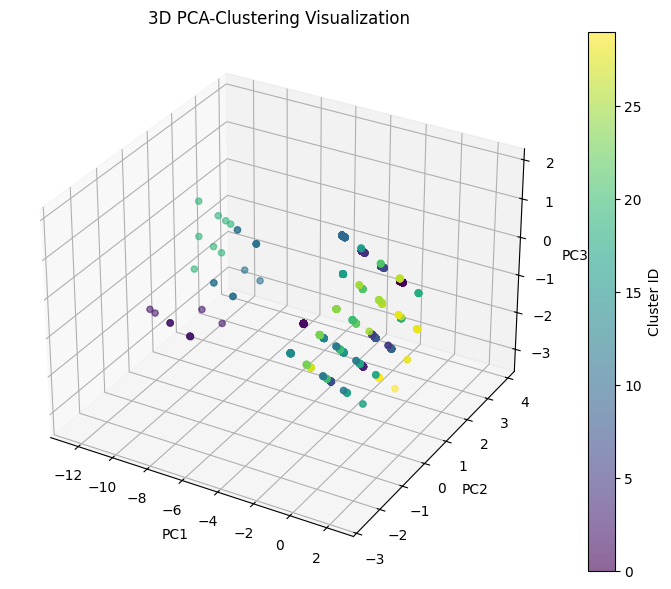

In [ ]:
visualize_clusters(trajectory_df_pca)

B: LLM FEEDBACK IMPLEMENTATION <br>
SECTION B.0: LOADING THE LLM
*   Step B.0.1: Install Required Libraries
*   Step B.0.2: Setting the environment varaible  
*   Step B.0.3: Setup and Load the Pretrained LLM

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

In [ ]:
%xterm
# Execute the following commands sequentially in Xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull mistral
# ollama list
# ollama show mistral

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
def visualize_feedback_progress(progress):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Progress (%)")
    ax.set_ylabel("Completion")

    def update(frame):
        ax.clear()
        ax.barh(["LLM Feedback"], [frame], color='blue')
        ax.set_xlim(0, 100)
        ax.set_title("Live LLM Feedback Collection Progress")

    ani = animation.FuncAnimation(fig, update, frames=progress, repeat=False)
    plt.show()

In [ ]:
def get_llm_feedback(state, action, reward, next_state, episode_num, time_step, collision_flag, lane_index, pc1, pc2, pc3):
    """
    Query Mistral LLM for feedback on action effectiveness and reward appropriateness.
    The response is expected to be a JSON object with keys: justification, llm_score_1, llm_score_2.
    """
    prompt = f"""
            You are an expert in analyzing reinforcement learning trajectories in a highway environment.
            You will process a structured dataset containing agent trajectories and analyze each row by assessing whether:
            - the action taken is effective or not, and
            - whether the reward awarded is appropriate or not.

            You are provided with the following trajectory information:
            - Episode: {episode_num}
            - Time Step: {time_step}
            - State: {state}
            - Action taken by agent: {action}
            - Reward: {reward}
            - Next state: {next_state}
            - Collision Flag: {collision_flag}
            - Lane Index: {lane_index}
            - Principal Components: PC1 = {pc1}, PC2 = {pc2}, PC3 = {pc3}

            Based on this data, evaluate and return feedback as a JSON object with the following format:

            {{
               "justification": "<brief explanation of your decision>",
               "llm_score_1": <integer>,   // +2 for effective, 0 for neutral, -2 for ineffective
               "llm_score_2": <integer>    // +1 if reward is appropriate, -1 if inappropriate
             }}

             Only return a valid JSON object with no surrounding commentary or explanation.
            """

    answer = ollama.generate(model="mistral", prompt=prompt, options={"temperature": 0.6, "seed": 4})
    response_text = answer['response'].strip()

    # Clean and parse the JSON safely
    try:
        # Attempt to extract only the JSON portion if other text is included
        json_start = response_text.find('{')
        json_end = response_text.rfind('}') + 1
        json_text = response_text[json_start:json_end]

        feedback = json.loads(json_text)
    except Exception as e:
        print(f"⚠️ Failed to parse JSON from LLM response:\n{response_text}\nError: {e}")
        feedback = {
            "justification": "Parsing error",
            "llm_score_1": 0,
            "llm_score_2": 0
        }

    return feedback

In [ ]:
def collect_llm_feedback_cluster(cluster_representatives):
    """
    Collect LLM feedback for each cluster representative assuming JSON-style response.
    Returns:
        - llm_feedback_data (dict): Cluster ID → full feedback (dict)
        - feedback_df (DataFrame): Contains Cluster ID, justification, llm_score_1, llm_score_2
    """
    llm_feedback_data = {}
    feedback_records = []

    for i, (_, row) in tqdm(enumerate(cluster_representatives.iterrows()), total=len(cluster_representatives)):
        # Get LLM response (expected to return a JSON/dict-like structure)
        feedback = get_llm_feedback(
            row["state"], row["action"], row["reward"], row["next_state"],
            row["episode"], row["time_step"], row["collision_flag"], row["lane_index"],
            row["PC1"], row["PC2"], row["PC3"]
        )

        cluster_id = row["Cluster"]
        llm_feedback_data[cluster_id] = feedback

        # Try to parse feedback if it's a stringified JSON
        if isinstance(feedback, str):
            try:
                feedback = eval(feedback)  # or json.loads(feedback) if fully valid JSON
            except Exception as e:
                print(f"Error parsing LLM feedback for Cluster {cluster_id}: {e}")
                feedback = {}

        # Extract values from feedback dictionary
        justification = feedback.get("justification", "N/A")
        score_1 = feedback.get("llm_score_1", 0)
        score_2 = feedback.get("llm_score_2", 0)

        print(f"\n--- Cluster {cluster_id} ---")
        print(f"Justification: {justification}")
        print(f"llm_score_1: {score_1}, llm_score_2: {score_2}")

        feedback_records.append({
            "Cluster": cluster_id,
            "Justification": justification,
            "LLM_Score_1": score_1,
            "LLM_Score_2": score_2,
            "LLM_Score_Total": score_1 + score_2
        })

    # Convert records into a DataFrame
    feedback_df = pd.DataFrame(feedback_records)
    return llm_feedback_data, feedback_df

In [ ]:
llm_feedback_data, llm_feedback_df = collect_llm_feedback_cluster(cluster_representatives)


  3%|▎         | 1/30 [00:11<05:38, 11.67s/it]

⚠️ Failed to parse JSON from LLM response:
{
  "justification": "The action taken by the agent resulted in a positive reward (0.73), indicating a generally effective action. However, since there is no state provided, it's difficult to assess the specific context of this action. The principal components also don't provide enough information to make a definitive judgment about the effectiveness of the action. Regarding the reward, it seems appropriate as it's positive and within reasonable bounds for this environment. However, without knowledge of the maximum possible reward or the scale of rewards in this context, it's hard to be certain.",
  "llm_score_1": 0, // Neutral due to lack of context about the action's effectiveness
  "llm_score_2": 1 // Reward appears appropriate
}
Error: Expecting property name enclosed in double quotes: line 3 column 21 (char 625)

--- Cluster 0 ---
Justification: Parsing error
llm_score_1: 0, llm_score_2: 0


  7%|▋         | 2/30 [00:14<02:55,  6.27s/it]


--- Cluster 1 ---
Justification: The action taken by the agent (Lane Change) resulted in a positive reward, indicating a successful maneuver. However, the lack of state information makes it difficult to definitively label the action as 'effective'. The reward appears appropriate for this scenario.
llm_score_1: 0, llm_score_2: 1


 10%|█         | 3/30 [00:17<02:17,  5.09s/it]


--- Cluster 2 ---
Justification: The action taken by the agent resulted in a collision (Lane Index: 3, Collision Flag: 1), indicating it was an ineffective action. The reward seems to be slightly positive (Reward: 0.07520053663809241), which might suggest some minor positive outcome despite the collision. However, in a safety-critical environment like a highway, even a small reward could be considered inappropriate.
llm_score_1: -2, llm_score_2: -1


 13%|█▎        | 4/30 [00:20<01:46,  4.08s/it]


--- Cluster 3 ---
Justification: The action taken by the agent (lane change) resulted in a positive reward, suggesting it was effective (+2 for llm_score_1). The reward appears to be appropriate given the context of the highway environment (+1 for llm_score_2).
llm_score_1: 2, llm_score_2: 1


 17%|█▋        | 5/30 [00:22<01:25,  3.43s/it]


--- Cluster 4 ---
Justification: The action taken by the agent resulted in a positive reward (0.7117842841295731), indicating some level of success, hence llm_score_1 is 2. The reward seems appropriate based on the context provided, thus llm_score_2 is 1.
llm_score_1: 0, llm_score_2: 0


 20%|██        | 6/30 [00:25<01:15,  3.13s/it]


--- Cluster 5 ---
Justification: The action taken by the agent resulted in a non-zero reward and did not cause a collision, indicating some level of effectiveness. However, the state at this time step is missing, making a definitive conclusion difficult. The reward seems appropriate for the given situation.
llm_score_1: 0, llm_score_2: 1


 23%|██▎       | 7/30 [00:28<01:15,  3.30s/it]


--- Cluster 6 ---
Justification: The action taken by the agent (changing lane) seems to have led to a positive outcome as there was no collision and the reward was given. However, without context about the specific highway environment, traffic conditions, and the agent's objectives, it is difficult to definitively say if this was the optimal action. The principal components suggest some changes in the state of the environment but their interpretation requires further analysis. As for the reward, it seems appropriate based on the positive outcome.
llm_score_1: 2, llm_score_2: 1


 27%|██▋       | 8/30 [00:31<01:07,  3.07s/it]


--- Cluster 7 ---
Justification: The action taken by the agent resulted in a positive reward (0.7), indicating it may have been effective. However, without the state information, it's difficult to definitively say if the action was optimal. The reward appears appropriate based on its positive value.
llm_score_1: 0, llm_score_2: 1


 30%|███       | 9/30 [00:34<01:04,  3.06s/it]


--- Cluster 8 ---
Justification: The action taken by the agent resulted in a positive reward (0.733) and there was no collision, indicating that the action might have been effective. However, without knowing the specific state of the environment at this time step, it's difficult to definitively label it as 'effective'. The reward seems appropriate given the context of the highway environment.
llm_score_1: 0, llm_score_2: 1


 33%|███▎      | 10/30 [00:38<01:04,  3.21s/it]


--- Cluster 9 ---
Justification: The action taken by the agent (lane change) resulted in a positive reward (+0.86), indicating it was an effective action. The principal components suggest the state of the environment might have been complex, but the lane change seems to have been beneficial. However, the absence of a next state and lack of specific details about the state make it challenging to fully confirm the effectiveness. As for the reward, it appears appropriate given the positive outcome.
llm_score_1: 2, llm_score_2: 1


 37%|███▋      | 11/30 [00:41<01:00,  3.16s/it]


--- Cluster 10 ---
Justification: The action taken by the agent resulted in a positive reward (+0.667), which suggests it was effective. However, the next state is not provided, so we can't definitively say if the action led to the optimal outcome. The reward seems appropriate given the context of the highway environment. Therefore, the scores are set accordingly.
llm_score_1: 2, llm_score_2: 1


 40%|████      | 12/30 [00:44<00:56,  3.12s/it]


--- Cluster 11 ---
Justification: The action taken by the agent resulted in a collision (Collision Flag = 1), which indicates it was not effective (-2 for llm_score_1). The reward seems to be non-zero, but a collision typically results in a significant negative reward, so it appears inappropriate (-1 for llm_score_2).
llm_score_1: -2, llm_score_2: -1


 43%|████▎     | 13/30 [00:46<00:49,  2.93s/it]


--- Cluster 12 ---
Justification: The action taken by the agent resulted in a positive reward (0.9294396281688483), indicating it was generally effective, and the reward appears to be appropriate based on the provided data.
llm_score_1: 2, llm_score_2: 1


 47%|████▋     | 14/30 [00:49<00:48,  3.04s/it]


--- Cluster 13 ---
Justification: The action taken by the agent (lane change) resulted in a positive reward, suggesting it was effective (+2 for llm_score_1). However, the absolute value of the reward is relatively high, which might indicate an overestimation or an exceptionally good state. Therefore, the reward awarded could be considered slightly inappropriate (-1 for llm_score_2).
llm_score_1: 2, llm_score_2: -1


 50%|█████     | 15/30 [00:52<00:44,  2.94s/it]


--- Cluster 14 ---
Justification: The action taken by the agent resulted in a positive reward (0.6687), indicating it may have been effective. However, without the state information, it's hard to definitively confirm this. The reward seems appropriate based on the context of the highway environment.
llm_score_1: 2, llm_score_2: 1


 53%|█████▎    | 16/30 [00:57<00:50,  3.59s/it]


--- Cluster 15 ---
Justification: At time step 1 of episode 1, the agent chose action 1 and received a reward of 0.715. Since we don't have the state information, it is impossible to definitively determine if the action was effective. However, since the reward is positive, it indicates some form of positive reinforcement. The collision flag is 0, indicating no collision occurred. The principal components suggest a change in the agent's position or velocity, which could be relevant in a dynamic highway environment. Based on this information, we cannot determine if the action was effective (llm_score_1: 0), but the reward seems appropriate (llm_score_2: 1).
llm_score_1: 0, llm_score_2: 1


 57%|█████▋    | 17/30 [01:00<00:43,  3.32s/it]


--- Cluster 16 ---
Justification: The action taken by the agent (Lane Change) resulted in a positive reward (+0.82), indicating it was an effective move. However, the state and next state are nan, which suggests that there might be missing data. The reward seems appropriate given the context.
llm_score_1: 2, llm_score_2: 1


 60%|██████    | 18/30 [01:04<00:41,  3.45s/it]


--- Cluster 17 ---
Justification: The action taken by the agent resulted in a positive reward (+0.84), which suggests it was effective. However, the absence of a state and next state makes it difficult to determine the exact context. Collision flag is 0, indicating no collision occurred. The principal components seem to be within the range of normal values for this environment, but without specific thresholds, it's hard to evaluate them definitively. The reward appears appropriate given the circumstances.
llm_score_1: 2, llm_score_2: 1


 63%|██████▎   | 19/30 [01:07<00:37,  3.44s/it]


--- Cluster 18 ---
Justification: The action taken by the agent (Action: 3) resulted in a non-zero reward (Reward: 0.8439952757658243), indicating a positive outcome, hence llm_score_1 is +2. The reward seems appropriate for the context of this action, thus llm_score_2 is +1.
llm_score_1: 2, llm_score_2: 1


 67%|██████▋   | 20/30 [01:11<00:34,  3.48s/it]


--- Cluster 19 ---
Justification: The action taken by the agent resulted in a collision (Lane Index: 1, Collision Flag: 1), therefore it is considered ineffective (-2). The reward seems to be too low for a collision event (Reward: 0.022222222222222216), which suggests that the environment does not appropriately penalize negative events (-1).
llm_score_1: -2, llm_score_2: -1


 70%|███████   | 21/30 [01:13<00:27,  3.09s/it]


--- Cluster 20 ---
Justification: The action taken by the agent resulted in a positive reward (0.8245), indicating a beneficial outcome for the current state, hence 'llm_score_1': 2. The reward seems appropriate for the given context, therefore 'llm_score_2': 1.
llm_score_1: 0, llm_score_2: 0


 73%|███████▎  | 22/30 [01:17<00:26,  3.31s/it]


--- Cluster 21 ---
Justification: The action taken by the agent resulted in a positive reward (0.8449), indicating an effective maneuver. However, the absence of state and next state data makes it difficult to provide more detailed analysis. The collision flag is also zero, which means no collision occurred. The principal components suggest some degree of steering or lane change, as PC1 is significantly positive (0.8436), while PC2 and PC3 are close to zero.
llm_score_1: 2, llm_score_2: 1


 77%|███████▋  | 23/30 [01:20<00:22,  3.23s/it]


--- Cluster 22 ---
Justification: The action taken by the agent resulted in a positive reward (0.7), which suggests it was effective. However, the state is missing, making a definitive conclusion difficult. The reward seems appropriate for this context. Therefore, LLM_score_1: 2, LLM_score_2: 1
llm_score_1: 2, llm_score_2: 1


 80%|████████  | 24/30 [01:23<00:19,  3.27s/it]


--- Cluster 23 ---
Justification: The action taken by the agent (Lane Change) resulted in a positive reward (+0.7999999999999999), indicating a successful maneuver without collision, as evidenced by the Collision Flag (0). The principal components suggest a change of state in the environment, which supports the effectiveness of the action taken.
llm_score_1: 2, llm_score_2: 1


 83%|████████▎ | 25/30 [01:26<00:15,  3.19s/it]


--- Cluster 24 ---
Justification: The action taken by the agent resulted in a positive reward (0.688888888888889), indicating it was effective (+2 for llm_score_1). The reward seems appropriate for the given state and action (+1 for llm_score_2).
llm_score_1: 2, llm_score_2: 1


 87%|████████▋ | 26/30 [01:30<00:13,  3.30s/it]


--- Cluster 25 ---
Justification: The action taken by the agent resulted in a positive reward (0.9105), indicating it was an effective choice. However, the reward seems high for this single step, suggesting potential overestimation or environmental complexity not fully captured by the current state representation. The collision flag is 0, and the lane index remains at 0, which implies no collisions occurred and the agent stayed in its initial lane.
llm_score_1: 2, llm_score_2: -1


 90%|█████████ | 27/30 [01:33<00:09,  3.23s/it]


--- Cluster 26 ---
Justification: The action taken by the agent resulted in a slight deviation from the current lane (Lane Index: 2 to PC3), but no collision occurred (Collision Flag: 0). The reward seems reasonable for this action, considering it was not a critical situation. However, the state is missing at this time step.
llm_score_1: 0, llm_score_2: 1


 93%|█████████▎| 28/30 [01:36<00:06,  3.14s/it]


--- Cluster 27 ---
Justification: The action taken by the agent resulted in a positive reward (0.688888888888889), indicating it was generally effective, but the state data is missing making a definitive conclusion difficult. The reward appears to be appropriate based on the positive value.
llm_score_1: 2, llm_score_2: 1


 97%|█████████▋| 29/30 [01:40<00:03,  3.46s/it]


--- Cluster 28 ---
Justification: The action taken by the agent resulted in a slight increase in PC1 (a positive change), which could suggest a move towards the desired lane. However, there is no state information provided to fully determine the effectiveness of the action. The reward of 0.95 is not typical for a single step but could be appropriate depending on the context and long-term goals. Therefore, llm_score_1: 0 (neutral) and llm_score_2: 1 (reward seems appropriate).
llm_score_1: 0, llm_score_2: 1


100%|██████████| 30/30 [01:43<00:00,  3.43s/it]


--- Cluster 29 ---
Justification: The action taken (lane change) seems effective as there was no collision (Collision Flag: 0). However, the reward of 0.86 is somewhat high for this specific action in the given state, which appears to be missing from the provided data.
llm_score_1: 2, llm_score_2: -1


In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_feedback_df)

,Cluster,Justification,LLM_Score_1,LLM_Score_2,LLM_Score_Total
0,0,Parsing error,0,0,0
1,1,The action taken by the agent (Lane Change) re...,0,1,1
2,2,The action taken by the agent resulted in a co...,-2,-1,-3
3,3,The action taken by the agent (lane change) re...,2,1,3
4,4,The action taken by the agent resulted in a po...,0,0,0
5,5,The action taken by the agent resulted in a no...,0,1,1
6,6,The action taken by the agent (changing lane) ...,2,1,3
7,7,The action taken by the agent resulted in a po...,0,1,1
8,8,The action taken by the agent resulted in a po...,0,1,1
9,9,The action taken by the agent (lane change) re...,2,1,3


In [ ]:
llm_feedback_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/2_llm_feedback/0_llm_d_justification.pkl')            # Update directory Location 2

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def interpolate_llm_scores(trajectory_df_pca, llm_feedback_df):
    """
    Assigns LLM feedback scores (from llm_feedback_df) to each trajectory row using cluster mapping,
    and interpolates missing scores.
    """
    # Create mapping: Cluster ID → LLM_Score_Total
    cluster_to_score = dict(zip(llm_feedback_df["Cluster"], llm_feedback_df["LLM_Score_Total"]))

    # Map score to each row in trajectory_df_pca
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["Cluster"].map(cluster_to_score)

    # Interpolate missing values if any (e.g., if some clusters were missed)
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["LLM_Feedback_Score"].interpolate()

    return trajectory_df_pca

In [ ]:
llm_score_df = interpolate_llm_scores(trajectory_df_pca, llm_feedback_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_score_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group the data by 'episode'
episode_data = trajectory_df_pca.groupby('episode')
# Loop through each episode
for episode, data in episode_data:

    cluster_list = data['Cluster'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {cluster_list}")

Episode 0:Total timesteps 40: [23, 25, 12, 16, 20, 20, 4, 14, 10, 10, 16, 10, 1, 10, 10, 14, 1, 1, 14, 10, 14, 10, 10, 10, 1, 10, 1, 1, 1, 10, 10, 1, 10, 10, 1, 14, 14, 10, 24, 14]
Episode 1:Total timesteps 40: [6, 15, 6, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 7, 6, 8, 0, 3, 0, 0, 8, 0, 7, 6, 27, 4, 4, 4, 13, 4, 14, 1, 1, 10, 24, 4, 4, 14, 10, 1]
Episode 2:Total timesteps 40: [0, 0, 0, 18, 9, 0, 3, 3, 18, 0, 7, 26, 9, 9, 0, 0, 8, 0, 0, 0, 3, 3, 18, 9, 9, 17, 28, 26, 6, 6, 6, 6, 27, 4, 4, 13, 4, 22, 6, 15]
Episode 3:Total timesteps 40: [10, 14, 1, 1, 10, 24, 13, 4, 22, 15, 27, 4, 4, 13, 22, 6, 15, 6, 6, 8, 0, 0, 0, 18, 0, 7, 6, 27, 4, 14, 1, 10, 10, 10, 1, 1, 1, 10, 1, 10]
Episode 4:Total timesteps 40: [6, 6, 15, 6, 15, 8, 0, 8, 7, 8, 0, 3, 0, 0, 3, 0, 8, 0, 0, 8, 3, 8, 0, 0, 0, 3, 18, 29, 0, 0, 3, 8, 8, 18, 0, 0, 0, 0, 8, 18]
Episode 5:Total timesteps 20: [10, 10, 10, 14, 1, 10, 16, 10, 24, 22, 6, 26, 20, 25, 12, 12, 12, 12, 16, 19]
Episode 6:Total timesteps 40: [20, 20, 20, 5, 28, 26, 6, 26, 1

In [ ]:
# Group the data by 'episode'
episode_data = llm_score_df.groupby('episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
    llm_score_list = data['LLM_Feedback_Score'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {llm_score_list}")

Episode 0:Total timesteps 40: [3, 1, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3]
Episode 1:Total timesteps 40: [3, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 0, 3, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 1, 0, 3, 1, 1, 3, 3, 0, 0, 3, 3, 1]
Episode 2:Total timesteps 40: [0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 1, 1, 3, 3, 0, 0, 1, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 0, 1, 0, 3, 3, 1]
Episode 3:Total timesteps 40: [3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 3, 0, 0, 1, 3, 3, 1, 3, 3, 1, 0, 0, 0, 3, 0, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3]
Episode 4:Total timesteps 40: [3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 0, 3, 0, 0, 3, 0, 1, 0, 0, 1, 3, 1, 0, 0, 0, 3, 3, 1, 0, 0, 3, 1, 1, 3, 0, 0, 0, 0, 1, 3]
Episode 5:Total timesteps 20: [3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, -3]
Episode 6:Total timesteps 40: [0, 0, 0, 1, 1, 1, 3, 1, 3, 3, 1, 0, 0, 1, 3, 0, 1, 3, 1, 1, 1, 0, 1, 0, 0, 1, 3, 1, 0, 1, 0, 3, 1, 3, 0, 1, 1, 1, 1, 1]
Ep

Section B.2: REWARD MODELLING(LLM FEEDBACK)

*   Step B.2.1: Recalibrate Reward Based on LLM Feedback
*   Step 3.2.2: Displaying the recalibrated rewards based on LLM feedback
*   Step 3.2.3: Access the reward for a specific step

In [ ]:
# Step B.2.3: Recalibrate Reward Based on LLM Feedback
# Function to recalibrate the rewards
def recalibrate_rewards(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create the 'Recalibrated_rewards' column
    df_copy['Recalibrated_rewards'] = df_copy['reward'] + df_copy['LLM_Feedback_Score']

    # Get the list of recalibrated rewards
    recalibrated_rewards_list = df_copy['Recalibrated_rewards'].tolist()

    return df_copy, recalibrated_rewards_list

In [ ]:
# Apply the function to recalibrate rewards
recalibrated_df, recalibrated_rewards_list = recalibrate_rewards(llm_score_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(recalibrated_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
recalibrated_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/2_llm_feedback/1_llm_direct.pkl')         # Update directory location 3

In [ ]:
episode_data = recalibrated_df.groupby('episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
     recalibrated_reward_l = data['Recalibrated_rewards'].tolist()

     # Count the total number of time steps in the episode
     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

     print(f"Episode {episode}:Total timesteps {total_timesteps}: {recalibrated_reward_l}")

Episode 0:Total timesteps 40: [3.8, 1.9105482353831813, 3.9294396281688484, 3.8221197095484385, 0.8245128840260193, 0.8228564886726687, 0.7117842841295731, 3.6687138988604007, 3.6673119774741734, 3.666780683824668, 3.777234425788464, 3.6855613960920564, 1.6698955536235616, 3.6672184454585546, 3.666760959170317, 3.6666827801461537, 1.66666942027073, 1.666667137225204, 3.666666747079584, 3.666666680408288, 3.666666669014948, 3.66666666706796, 3.6666666667352428, 3.6666666666783856, 1.6666666666686694, 3.666666666667009, 1.6666666666667251, 1.6666666666666767, 1.6666666666666683, 3.666666666666667, 3.666666666666667, 1.666666666666667, 3.666666666666667, 3.666666666666667, 1.666666666666667, 3.666666666666667, 3.666666666666667, 3.666666666666667, 3.688888888888889, 3.6666666666666665]
Episode 1:Total timesteps 40: [3.733896209061263, 1.7150048162755964, 3.7117764995128244, 1.7333333333333334, 0.7333333333333334, 0.7333364176553144, 0.7333338983903303, 0.7333334302789357, 0.73333334990407

In [ ]:
# To access the reward for a specific step:
# for i, feedback in enumerate(recalibrated_rewards_list):
#     human_recalibrated_reward_for_step = recalibrated_rewards_list[i]
#     print(f"Recalibrated reward for step {i}: {human_recalibrated_reward_for_step}")

SECTION A.5: MODEL TRAINING(LLM FEEDBACK DIRECT)
*   Step A.5.1: CUSTOM REWARD FUNCTION
*   Step A.5.2: LOAD THE SAVED INITIALLY TRAINED PPO MODEL FROM GOOGLE DRIVE
*   Step A.5.3: TRAIN/UPDATE PPO MODEL WITH RECALIBRATED REWARD
*   Step A.5.4: SAVE THE TRAINED MODEL(LLM_IDEAL) FOR TESTING

In [ ]:
# Step A.5.1: CUSTOM REWARD FUNCTION
def custom_reward(self, env, state, action, next_state, reward, done):
    # Access and recalculate the reward using human_feedback_data or recalibrate_rewards_human function
    global step_counter
    try:
        step_counter
    except NameError:
        step_counter = 0

    reward = recalibrated_rewards_list[step_counter]
    step_counter += 1
    return reward

# Create a new environment class that wraps your original environment and overrides the default reward function with your custom function
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        reward = custom_reward(self, self.env, self.last_obs, action, next_state, reward, done)
        # custom_reward should be defined and accessible to your class
        self.last_obs = next_state
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        global step_counter
        step_counter = 0
        self.last_obs = self.env.reset(**kwargs)[0]  # Assuming Gymnasium env returns (obs, info)
        return self.last_obs, {}  # Assuming Gymnasium env requires (obs, info)
# Create and wrap the environment with your custom reward wrapper
# env_human = CustomRewardWrapper(gym.make('highway-v0'))

PPO training and Training logs

In [ ]:
drive_log_dir = "/content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/7_log_dir/7_ppo_highway_llmf_direct_ideal_1"             # Update directory location 4

In [ ]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=10000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomRewardWrapper(gym.make("highway-v0"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/01_trained_models/7_ppo_highway_llmf_direct_ideal_1')      # Update directory location 5
    return model, log_dir

In [ ]:
# log_path = os.path.join(drive_log_dir, "monitor.csv")
# df = pd.read_csv(log_path, skiprows=1)
## Ensure episodes are logged correctly
# df.reset_index(inplace=True)
# df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [ ]:
# data_table.enable_dataframe_formatter()
# data_table.DataTable(df)

In [ ]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=10000)

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/7_log_dir/7_ppo_highway_llmf_direct_ideal_1/PPO_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.7     |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 830      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.3        |
|    ep_rew_mean          | 43.9        |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 1659        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014468489 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.000591   |
|    learning_rate        | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path '/content/drive/MyDrive/05_zero_shot_llm_3/02_data/1_trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
